<a href="https://colab.research.google.com/github/AdamClarkStandke/GenerativeDeepLearning/blob/main/StableDiffustion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Conditional Latent Diffusion Model (Stable Diffusion)



---

## Background

Stable Diffusion stems from the paper [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/pdf/2112.10752.pdf) a joint project between [Ludwig Maximilian University of Munich & IWR](https://ommer-lab.com/) and [Runway ML](https://runwayml.com/). Stable Diffusion is a form of Multimodal Learning which most people (namely me) consider to be the future of generative learning. As stated in [Generative Deep Learning: Teaching Machines To Paint, Write, Compose, and Play](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=asc_df_1098134184/?tag=hyprod-20&linkCode=df0&hvadid=632163212339&hvpos=&hvnetw=g&hvrand=14059992483304092225&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=9006587&hvtargid=pla-1852750701094&psc=1&mcid=e1431dcee2ae37808a9d62e277627154&gclid=Cj0KCQiAkKqsBhC3ARIsAEEjuJj0ac3q0MjvImuQ2N8gFCvcZAO9DwPeKXhdMyDrXfNHztPzxH2kaO4aApI3EALw_wcB):

> Multimodal learning involves training generative models to convert between two or more different kinds of data.Some of the most impressive generative models introduced in the last two years have been multimodal in nature...we will explore how they work in detail and consider *how the future of generative modeling will be shaped by large multimodal models*(emphasis added).

What seperates Stable Diffusion from other text to image multimodal models such as DALL.E and Imagen is that Stable Diffusion wraps an Auto-Encoder architecture over a diffusion model so that the diffusion process takes place in latent space. This allows for significant computational advantages not present in other multimodal models. As the authors from [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/pdf/2112.10752.pdf) state:


> [W]e utilize an autoencoding model which learns a space that is perceptually equivalent to the image space, but offers significantly reduced computational complexity.Such an approach offers several advantages: (i) *By leaving the high-dimensional image space, we obtain DMs which are computationally much more efficient because sampling is performed on a low-dimensional space* (emphasis added).

To train Stable Diffusion from sratch the Autoencoder must first be trained. As the authors from [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/pdf/2112.10752.pdf) state:


> We train all our autoencoder models in an adversarial manner...such that a patch-based discriminator $D_{\Psi }$ is optimized to differentiate original images from reconstructions $D(E(x))$ To avoid arbitrarily scaled latent spaces, we regularize the latent *z* to be zero centered and obtain small
> variance by introducing an regularizing loss term $L_{regularization}$...[which is]  a low-weighted Kullback-Leibler-term between $q_{E}(z|x)= N(z;E_{\mu}, E_{σ^2})$ and a standard normal distribution...[t]he full objective to train the autoencoding model (E, D) reads:
\begin{align} L_{Autoencoder}=min_{E,D}max_{\psi}(L_{reconstruction}(x, D(E(x)))-L_{adversarial}(D(E(x)))+logD_{\psi} +L_{regularization}(x;E,D)) \end{align}

After training the Autoencoder from scratch there are different approaches one can take to train a text-conditional latent diffusion model. One approch as detailed in the paper is to jointly train the diffusion model and an unmasked transformer.

As the authors from [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/pdf/2112.10752.pdf) state:

> Based on image-conditioning pairs, we then learn the conditional LDM via $L_{LDM}=\mathbb{E}_{E(x),y,\epsilon\sim N(0,1), t}[\parallel \epsilon-\epsilon_{\theta}(z_t, t, τ_{θ}(y))\parallel^2_2]$ where both $τ_{θ}$ and $\epsilon_{\theta}$ are jointly optimized [note: this was not done in the intial relase rather $τ_{θ}$ was a pre-trained Clip model]...[t]his conditioning mechanism is flexible as $τ_{θ}$ can be parameterized with domain-specific experts, e.g. (unmasked) transformers...where y are text prompts

> For text-to-image modeling, we train a 1.45B parameter KL-regularized LDM conditioned on language prompts on [LAION-400M](https://laion.ai/)...[w]e employ the BERT-tokenizer...and implement $τ_{θ}$ as a transformer...to infer a latent code which is mapped into the UNet via (multi-head) cross-attention.

These are some of the hyperparameters used by the authors from [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/pdf/2112.10752.pdf) when training their text-conditional LDM (i.e. Stable Diffusion):

**Hyperparameters of Conditional Latent Diffusion Model:**

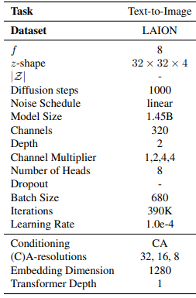

**Hyperparameters of Unmasked Transformer:**

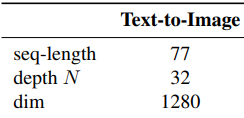










---


## Stable Diffusion v1-4 Model


I will not be training from sratch the text-conditional LDM (Stable Diffusion) but will be loading the pre-trained model as found at [Stable-Diffusion-v1-4 ](https://huggingface.co/CompVis/stable-diffusion-v1-4).
As the authors of [Stable-Diffusion-v1-4 ](https://huggingface.co/CompVis/stable-diffusion-v1-4) state:

> The Stable-Diffusion-v1-4 checkpoint was initialized with the weights of the Stable-Diffusion-v1-2 checkpoint and subsequently fine-tuned on 225k steps at resolution 512x512 on ["laion-aesthetics v2 5+"](https://laion.ai/blog/laion-aesthetics/) and *10% dropping of the text-conditioning* to improve [classifier-free guidance sampling](https://arxiv.org/pdf/2207.12598.pdf)...the model uses a fixed, pretrained text encoder ([CLIP ViT-L/14](https://arxiv.org/pdf/2103.00020.pdf)) as suggested in the [Imagen paper](https://arxiv.org/pdf/2205.11487.pdf)

I will now try and detail the [training procedure](https://huggingface.co/CompVis/stable-diffusion-v1-4) of the v1-4 model with some [code snippets](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L25):

1.   Images are encoded through an encoder, which turns images into latent representations. The autoencoder uses a relative downsampling factor of 8 and maps images of shape H x W x 3 to latents of shape H/f x W/f x 4

**[Image Encoder](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/autoencoders/autoencoder_kl.py)**

```
class AutoencoderKL(ModelMixin, ConfigMixin, FromOriginalVAEMixin):
    """
    A VAE model with KL loss for encoding images into latents and decoding latent representations into images.

    def encode(
        self, x: torch.FloatTensor, return_dict: bool = True
    ) -> Union[AutoencoderKLOutput, Tuple[DiagonalGaussianDistribution]]:
        """
        Encode a batch of images into latents.

        Args:
            x (`torch.FloatTensor`): Input batch of images.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether to return a [`~models.autoencoder_kl.AutoencoderKLOutput`] instead of a plain tuple.

        Returns:
                The latent representations of the encoded images. If `return_dict` is True, a
                [`~models.autoencoder_kl.AutoencoderKLOutput`] is returned, otherwise a plain `tuple` is returned.
        """
        if self.use_tiling and (x.shape[-1] > self.tile_sample_min_size or x.shape[-2] > self.tile_sample_min_size):
            return self.tiled_encode(x, return_dict=return_dict)

        if self.use_slicing and x.shape[0] > 1:
            encoded_slices = [self.encoder(x_slice) for x_slice in x.split(1)]
            h = torch.cat(encoded_slices)
        else:
            h = self.encoder(x)

        moments = self.quant_conv(h)
        posterior = DiagonalGaussianDistribution(moments)

        if not return_dict:
            return (posterior,)

        return AutoencoderKLOutput(latent_dist=posterior)    

```

2.   Text prompts are encoded through a [ViT-L/14]((https://arxiv.org/pdf/2103.00020.pdf) text-encoder which consists of the follwoing:

> The text encoder is a Transformer...[a]s a base size we use a 63M-parameter 12-layer 512-wide model with 8 attention heads. The transformer operates on a lower-cased byte pair encoding (BPE) representation of the text with a 49,152 vocab size...[f]or computational efficiency, the max sequence length was capped at 76. The text sequence is bracketed with [SOS] and [EOS] tokens and the activations of the highest layer of the transformer at the [EOS] token are treated as the feature representation of the text which is layer normalized and then *linearly projected into the multi-modal embedding space*(emphasis added).

**[ViT-L/14](https://github.com/huggingface/transformers/blob/main/src/transformers/models/clip/modeling_clip.py#L751)**
```
 """The text model from CLIP without any head or projection on top.""",
    CLIP_START_DOCSTRING,
)
class CLIPTextModel(CLIPPreTrainedModel):
    config_class = CLIPTextConfig

    _no_split_modules = ["CLIPTextEmbeddings", "CLIPEncoderLayer"]

    def __init__(self, config: CLIPTextConfig):
        super().__init__(config)
        self.text_model = CLIPTextTransformer(config)
        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self) -> nn.Module:
        return self.text_model.embeddings.token_embedding

    def set_input_embeddings(self, value):
        self.text_model.embeddings.token_embedding = value

    @add_start_docstrings_to_model_forward(CLIP_TEXT_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=BaseModelOutputWithPooling, config_class=CLIPTextConfig)
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPooling]:
        r"""
        Returns:

        Examples:

        ```python
        >>> from transformers import AutoTokenizer, CLIPTextModel

        >>> model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
        >>> tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

        >>> inputs = tokenizer(["a photo of a cat", "a photo of a dog"], padding=True, return_tensors="pt")

        >>> outputs = model(**inputs)
        >>> last_hidden_state = outputs.last_hidden_state
        >>> pooled_output = outputs.pooler_output  # pooled (EOS token) states
        ```"""
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        return self.text_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

```

3.   The non-pooled output of the text encoder is fed into the UNet backbone of the latent diffusion model via cross-attention.


**[latent diffusion model](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L118)**
```
def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        timesteps: List[int] = None,
        guidance_scale: float = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        ip_adapter_image: Optional[PipelineImageInput] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        guidance_rescale: float = 0.0,
        clip_skip: Optional[int] = None,
        callback_on_step_end: Optional[Callable[[int, int, Dict], None]] = None,
        callback_on_step_end_tensor_inputs: List[str] = ["latents"],
        **kwargs,
    ):
        r"""
        The call function to the pipeline for generation.
        """

        callback = kwargs.pop("callback", None)
        callback_steps = kwargs.pop("callback_steps", None)

        if callback is not None:
            deprecate(
                "callback",
                "1.0.0",
                "Passing `callback` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`",
            )
        if callback_steps is not None:
            deprecate(
                "callback_steps",
                "1.0.0",
                "Passing `callback_steps` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`",
            )

        # 0. Default height and width to unet
        height = height or self.unet.config.sample_size * self.vae_scale_factor
        width = width or self.unet.config.sample_size * self.vae_scale_factor
        # to deal with lora scaling and other possible forward hooks

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt,
            height,
            width,
            callback_steps,
            negative_prompt,
            prompt_embeds,
            negative_prompt_embeds,
            callback_on_step_end_tensor_inputs,
        )

        self._guidance_scale = guidance_scale
        self._guidance_rescale = guidance_rescale
        self._clip_skip = clip_skip
        self._cross_attention_kwargs = cross_attention_kwargs
        self._interrupt = False

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device

        # 3. Encode input prompt
        lora_scale = (
            self.cross_attention_kwargs.get("scale", None) if self.cross_attention_kwargs is not None else None
        )

        prompt_embeds, negative_prompt_embeds = self.encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            self.do_classifier_free_guidance,
            negative_prompt,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            lora_scale=lora_scale,
            clip_skip=self.clip_skip,
        )

        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        if self.do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

        if ip_adapter_image is not None:
            output_hidden_state = False if isinstance(self.unet.encoder_hid_proj, ImageProjection) else True
            image_embeds, negative_image_embeds = self.encode_image(
                ip_adapter_image, device, num_images_per_prompt, output_hidden_state
            )
            if self.do_classifier_free_guidance:
                image_embeds = torch.cat([negative_image_embeds, image_embeds])

        # 4. Prepare timesteps
        timesteps, num_inference_steps = retrieve_timesteps(self.scheduler, num_inference_steps, device, timesteps)

        # 5. Prepare latent variables
        num_channels_latents = self.unet.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 6.1 Add image embeds for IP-Adapter
        added_cond_kwargs = {"image_embeds": image_embeds} if ip_adapter_image is not None else None

        # 6.2 Optionally get Guidance Scale Embedding
        timestep_cond = None
        if self.unet.config.time_cond_proj_dim is not None:
            guidance_scale_tensor = torch.tensor(self.guidance_scale - 1).repeat(batch_size * num_images_per_prompt)
            timestep_cond = self.get_guidance_scale_embedding(
                guidance_scale_tensor, embedding_dim=self.unet.config.time_cond_proj_dim
            ).to(device=device, dtype=latents.dtype)

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        self._num_timesteps = len(timesteps)
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                if self.interrupt:
                    continue

                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if self.do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                noise_pred = self.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    timestep_cond=timestep_cond,
                    cross_attention_kwargs=self.cross_attention_kwargs,
                    added_cond_kwargs=added_cond_kwargs,
                    return_dict=False,
                )[0]

                # perform guidance
                if self.do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

                if self.do_classifier_free_guidance and self.guidance_rescale > 0.0:
                    # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
                    noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=self.guidance_rescale)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]

                if callback_on_step_end is not None:
                    callback_kwargs = {}
                    for k in callback_on_step_end_tensor_inputs:
                        callback_kwargs[k] = locals()[k]
                    callback_outputs = callback_on_step_end(self, i, t, callback_kwargs)

                    latents = callback_outputs.pop("latents", latents)
                    prompt_embeds = callback_outputs.pop("prompt_embeds", prompt_embeds)
                    negative_prompt_embeds = callback_outputs.pop("negative_prompt_embeds", negative_prompt_embeds)

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        step_idx = i // getattr(self.scheduler, "order", 1)
                        callback(step_idx, t, latents)

        if not output_type == "latent":
            image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False, generator=generator)[
                0
            ]
            image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)
        else:
            image = latents
            has_nsfw_concept = None

        if has_nsfw_concept is None:
            do_denormalize = [True] * image.shape[0]
        else:
            do_denormalize = [not has_nsfw for has_nsfw in has_nsfw_concept]

        image = self.image_processor.postprocess(image, output_type=output_type, do_denormalize=do_denormalize)

        # Offload all models
        self.maybe_free_model_hooks()

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)
```


4.   The loss is a reconstruction objective between the noise that was added to the latent and the prediction made by the UNet.


## Generating Images with StableDiffusionPipeline

In [ ]:
!pip install --upgrade diffusers[torch]

In [ ]:
!pip install --upgrade diffusers transformers scipy

In [38]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline

model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"


pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe = pipe.to(device)

prompt = "a biracial man sitting in golden arm chair with crown on head with world behind him,fantasy art"
image = pipe(prompt).images[0]

image.save("/content/generated_art.png")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

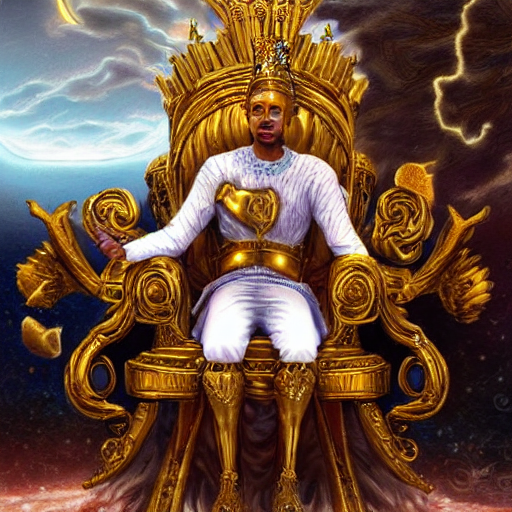

In [37]:
# Klaus Standke Der Elder
image

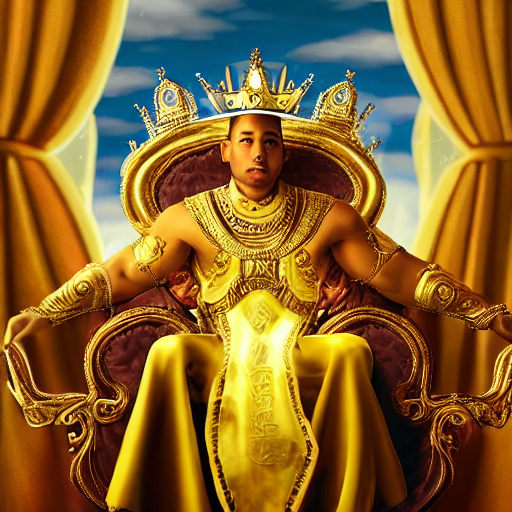

In [41]:
# King Adam Clark Standke der II
import PIL.Image
image = PIL.Image.open("/content/generated_art.png").convert("RGB")
image